#  **WeedsAI** - HIVE Project LiveAI
Transforming Farmers lives with Intelligent AI

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Hive_Agri')

In [3]:
import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import shutil
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from utils.events import download_google_drive_file
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
"""Global Variables"""

IMG_DIRECTORY = "./images/"
IMG_GD_ID = "1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj" # Check https://www.tensorflow.org/datasets/catalog/deep_weeds or https://github.com/AlexOlsen/DeepWeeds
IMG_ZIP_FILE = "./images/images.zip"
LABELS_URL = 'https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv'
IMG_H = 224
IMG_W = 224
IMG_SHAPE = (IMG_H,IMG_W, 3)
RDM_STATE = 43
CLASSES = ['Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative']

In [5]:
'''  Helper functions to download the dataset, make sure your notebook has access to utils.py '''

def download_dataset():
    if os.path.exists(IMG_DIRECTORY):
        logging.info("Found datasets folder, deleting..")
        shutil.rmtree(IMG_DIRECTORY)
    os.makedirs(IMG_DIRECTORY)
    logging.info("created image directory")
    download_google_drive_file(IMG_GD_ID, IMG_ZIP_FILE)
    logging.info("downloaded dataset from Google Drive")
    with ZipFile(IMG_ZIP_FILE,'r') as zip_ref:
        zip_ref.extractall(IMG_DIRECTORY)
        logging.info("Extracted .zip file")
        

def clear_zip():
    os.remove(IMG_ZIP_FILE)
    logging.info("Deleted .zip file")

In [6]:
"""Run only if you wnat to download the dataset. Code will be commented for precaution"""
download_dataset()
clear_zip()

<h1> Exploratory Analysis </h1>

Let's start by taking a look at the dataset




Negative          9106
Chinee apple      1125
Siam weed         1074
Lantana           1064
Prickly acacia    1062
Parkinsonia       1031
Parthenium        1022
Snake weed        1016
Rubber vine       1009
Name: Species, dtype: int64
17509


,Filename,Label,Species
12895,20180109-085214-1.jpg,8,Negative
13152,20180109-092212-2.jpg,8,Negative
17123,20180322-114503-1.jpg,8,Negative
12444,20180109-071659-2.jpg,8,Negative


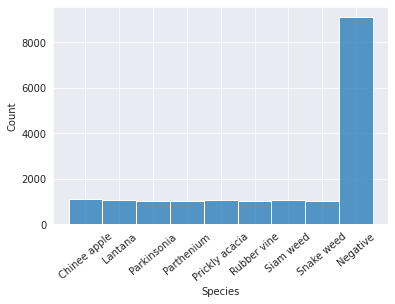

In [7]:
# Get the labels for the images
df = pd.read_csv(LABELS_URL)
print(df['Species'].value_counts())
print(len(df))
df.sort_values(by ='Label',inplace=True)
sns.set_style("darkgrid")
sns.histplot(df, x='Species')
plt.xticks(rotation=40)
df.sample(4)

In [ ]:
df['Weed'] = df['Species'] != 'Negative'
df['Weed'] = df['Weed'].astype(int).astype(str)
sns.histplot(df, x='Weed')
plt.xticks(rotation=40)
df.sample(4)

We clearly have an imbalanced dataset. There are several ways to tackle this:

+ Undersampling, oversampling, SMOTE -> No improvements using these. The model started to overfit a bit. SMOTE was not used
+ Getting more data -> No public data was found/
+ First tackle as a binary classification problem (Weed, not Weed) and then later classified in each species -> This was only tried in the early stages of the model without showing any improvement as tackling the problem as a multiclass one
+ Using class weights: The model learns more from the minority classes than from the majority ones -> This was the method that provided more improvements from all, especially by looking at the confusion matrix.


In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(df['Label']), df['Label'])
print(np.unique(df['Label']))
print(class_weights)
print('Note the labels, after the image genertor this might change')

[0 1 2 3 4 5 6 7 8]
[1.72928395 1.82842523 1.88694902 1.90356599 1.83186859 1.92809162
 1.81140079 1.91480752 0.21364424]


15.04803695903804

Lets take a look at random images from each class

In [10]:
def rdm_img_each_class():
    '''Shows a random image of each class '''
    _, ax = plt.subplots(1, 9, figsize = (30, 15))
    for j in range(9):
        df_label_j = df[df['Label'] == j]
        sample = df_label_j.sample()
        img_name = sample['Filename'].iloc[0]
        img_species = sample['Species'].iloc[0]
        path = os.path.join(IMG_DIRECTORY, img_name)
        img = plt.imread(path)
        ax[j].imshow(img)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(img_species)
    return None

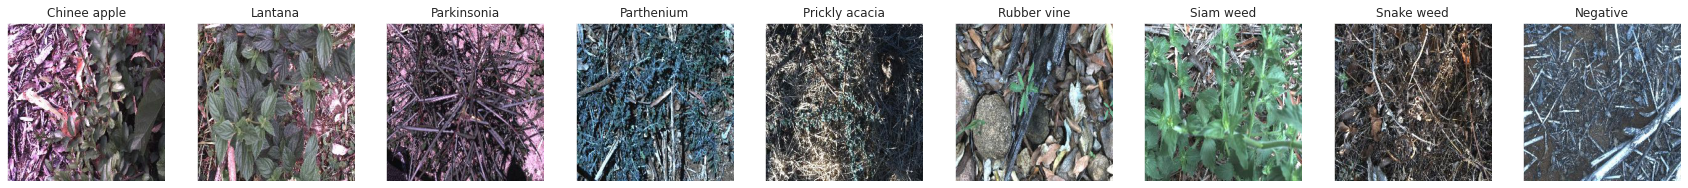

In [11]:
rdm_img_each_class()
rdm_img_each_class()

In [12]:
# Are all images same dimension?
def get_dim_for_all_images():
    """This function gets dimentions of all images     
    Returns: list of Heights, Widths and Channels for each image present in the folder
    """
    img_list = os.listdir(IMG_DIRECTORY)
    h_list = []
    w_list = []
    c_list = []
    for item in img_list:
          img = plt.imread(os.path.join(IMG_DIRECTORY, item))
          h_list.append(img.shape[0])
          w_list.append(img.shape[1])
          c_list.append(img.shape[2])
    return h_list, w_list, c_list


In [13]:
#dim1, dim2, colors = get_dim_for_all_images()
#print(np.mean(dim1), np.mean(dim2), np.mean(colors))
#sns.jointplot(dim1, dim2) 

<h1> Image Augmentation </h1>

First, split our dataset into training validation and test


In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state= RDM_STATE, stratify=df['Label'])
train, validation = train_test_split(train, test_size=0.25, random_state= RDM_STATE, stratify=train['Label'])
print(' We have a split of 60%, 20%, 20% for train, validation and test data: ',len(train), len(validation), len(test))

 We have a split of 60%, 20%, 20% for train, validation and test data:  10505 3502 3502


In [15]:
from keras.applications.resnet50 import preprocess_input

train_img_generator = ImageDataGenerator(
    rescale= 1 , #.0 / 255, 
    rotation_range = 360,
    width_shift_range=  0.2,
    shear_range= 0.2, 
    zoom_range= [0.6, 1], 
    horizontal_flip= True, 
    fill_mode= 'reflect', 
    channel_shift_range=20,
    brightness_range=[0.6,1.2],
    preprocessing_function = preprocess_input  # This preprocess function is applied after all the augmentation and prepares data as it was prepared on the Resnet50 paper
    )

validation_img_generator = ImageDataGenerator(rescale= 1, preprocessing_function = preprocess_input) #.0 / 255)
test_img_generator = ImageDataGenerator(rescale= 1, preprocessing_function = preprocess_input)

In [16]:
train_image_gen = train_img_generator.flow_from_dataframe(train, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=True, seed=RDM_STATE)
val_image_gen = train_img_generator.flow_from_dataframe(validation, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=True, seed=RDM_STATE)
test_image_gen = test_img_generator.flow_from_dataframe(test, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=False, seed=RDM_STATE)

Found 10505 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.


In [17]:
class2num = train_image_gen.class_indices
num2class = {value : key for (key, value) in class2num.items()}
class2num

{'Chinee apple': 0,
 'Lantana': 1,
 'Negative': 2,
 'Parkinsonia': 3,
 'Parthenium': 4,
 'Prickly acacia': 5,
 'Rubber vine': 6,
 'Siam weed': 7,
 'Snake weed': 8}

Now we create a dictionary with the class weight obtained earlier.

In [18]:
class_weights_dic = {0:1.72928395 , 1:1.82842523 , 2:0.21364424 , 3:1.88694902, 4:1.90356599, 5:1.83186859, 6:1.92809162, 7:1.81140079, 8:1.91480752 }

In [19]:
def rdm_img_from_gen():
    '''Shows a random image from the augmented data '''
    _, ax = plt.subplots(1, 9, figsize = (30, 15))
    for j in range(9):
        batch_gen=next(train_image_gen)  # returns the next batch of images and labels 
        # batch[0] is the images, batch[1] are the labels
        img=batch_gen[0][j]   # this is the first image  batch[0][1] would be the next image
        ax[j].imshow(img.astype(np.uint8))   
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(num2class[np.argmax(batch_gen[1][j])])
    return None

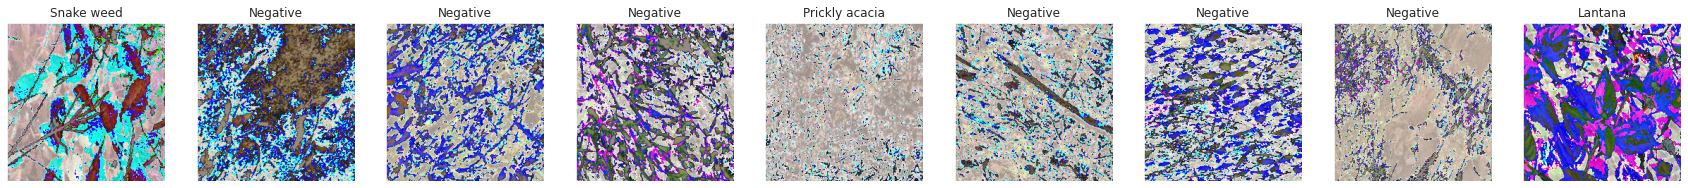

In [20]:
# Check images from the generator
rdm_img_from_gen()

<h1> Model </h1>
We will use transfer learning.

We start from a ResNet50 model and build a few new layers on top to adjust to our dataset.

We will also train a few of the last layers from the ResNet50.


We start by defining a few callbacks

In [21]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, verbose=1, restore_best_weights=True)
model_cp = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Hive_Agri/best_model8.h5', monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True ,save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=6, min_lr=0.00005, verbose=1)

Importing the Resnet50 model and selecting training layers

In [22]:
from tensorflow.keras.applications import ResNet50
pretrained_model=ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

for layer in pretrained_model.layers[:-19]:  # The number of layer frmo the resnet model that are trained is a hyperparameter. Choosing to train some layers form the conv5 part of resnet had improvements in accuracy
     layer.trainable = False                            


94773248/94765736 [==============================] - 1s 0us/step
True
True


In [23]:
# Add layers to pretrained model
tl_model = tf.keras.models.Sequential()
tl_model.add(pretrained_model)
tl_model.add(tf.keras.layers.GlobalAveragePooling2D())
#tl_model.add(tf.keras.layers.Dense(1024, activation='relu'))
tl_model.add(tf.keras.layers.Dense(512, activation='relu'))
tl_model.add(tf.keras.layers.Dropout(0.1))
tl_model.add(tf.keras.layers.Dense(9, activation='softmax'))


In [24]:
tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 24,641,417
Trainable params: 8,935,945
Non-trainable params: 15,705,472
_________________________________________________________________


In [25]:
opt=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
tl_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Training for high number of epochs

In [ ]:
tl_history = tl_model.fit(train_image_gen, epochs= 100, validation_data= val_image_gen, class_weight=class_weights_dic, shuffle=True, verbose=1, callbacks= [early_stopping, model_cp, reduce_lr])

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 0.9066 - accuracy: 0.6014
Epoch 00001: val_accuracy improved from -inf to 0.61165, saving model to /content/drive/My Drive/Hive_Agri/best_model8.h5
329/329 [==============================] - 204s 621ms/step - loss: 0.9066 - accuracy: 0.6014 - val_loss: 1.2754 - val_accuracy: 0.6117
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7223
Epoch 00002: val_accuracy improved from 0.61165 to 0.72816, saving model to /content/drive/My Drive/Hive_Agri/best_model8.h5
329/329 [==============================] - 205s 623ms/step - loss: 0.5966 - accuracy: 0.7223 - val_loss: 0.8241 - val_accuracy: 0.7282
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.7621
Epoch 00003: val_accuracy improved from 0.72816 to 0.75785, saving model to /content/drive/My Drive/Hive_Agri/best_model8.h5
329/329 [==============================] - 204s 619ms/step - loss: 

In [ ]:
plt.plot(tl_history.history['accuracy'])
plt.plot(tl_history.history['loss'])
plt.plot(tl_history.history['val_accuracy'])
plt.plot(tl_history.history['val_loss'])

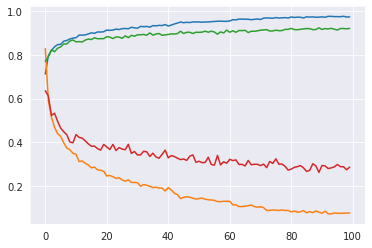

In [ ]:
# Old
plt.plot(tl_history.history['accuracy'])
plt.plot(tl_history.history['loss'])
plt.plot(tl_history.history['val_accuracy'])
plt.plot(tl_history.history['val_loss'])

In [ ]:
tl_model.save('/content/drive/My Drive/Hive_Agri/Agri_tl_augmentation8.h5')
pd.DataFrame.from_dict(tl_history.history).to_csv('/content/drive/My Drive/Hive_Agri/History_8.csv',index=False)

In [ ]:
tl_model.evaluate(test_image_gen)

110/110 [==============================] - 508s 5s/step - loss: 0.4137 - accuracy: 0.8849


[0.4136737585067749, 0.8849229216575623]

Model has 84% accuracy with no augmentation and an imbalanced dataset

**Load models from saved files**

In [ ]:
#tl_model = tf.keras.models.load_model('/content/drive/My Drive/Hive_Agri/best_model6.h5')
tl_model.load_weights('/content/drive/My Drive/Hive_Agri/best_model7.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = tl_model.predict(test_image_gen)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_gen.classes, y_pred, labels=[0, 1, 3, 4, 5, 6, 7, 8, 2])
mat = ((cf_matrix / cf_matrix.sum(axis=1, keepdims=True) )* 100)
fig = plt.subplots(figsize = (20, 10))
sns.heatmap(mat, annot=True, cmap='Greens', yticklabels=CLASSES, xticklabels=CLASSES)

Confusion Matrix


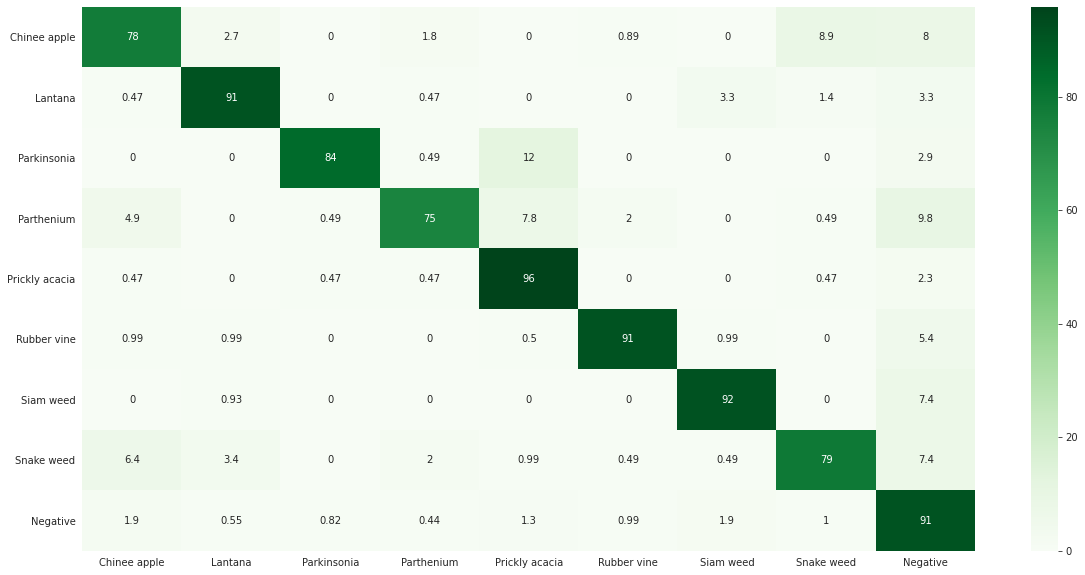

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_gen.classes, y_pred, labels=[0, 1, 3, 4, 5, 6, 7, 8, 2])
mat = ((cf_matrix / cf_matrix.sum(axis=1, keepdims=True) )* 100)
fig = plt.subplots(figsize = (20, 10))
sns.heatmap(mat, annot=True, cmap='Greens', yticklabels=CLASSES, xticklabels=CLASSES)

Confusion Matrix


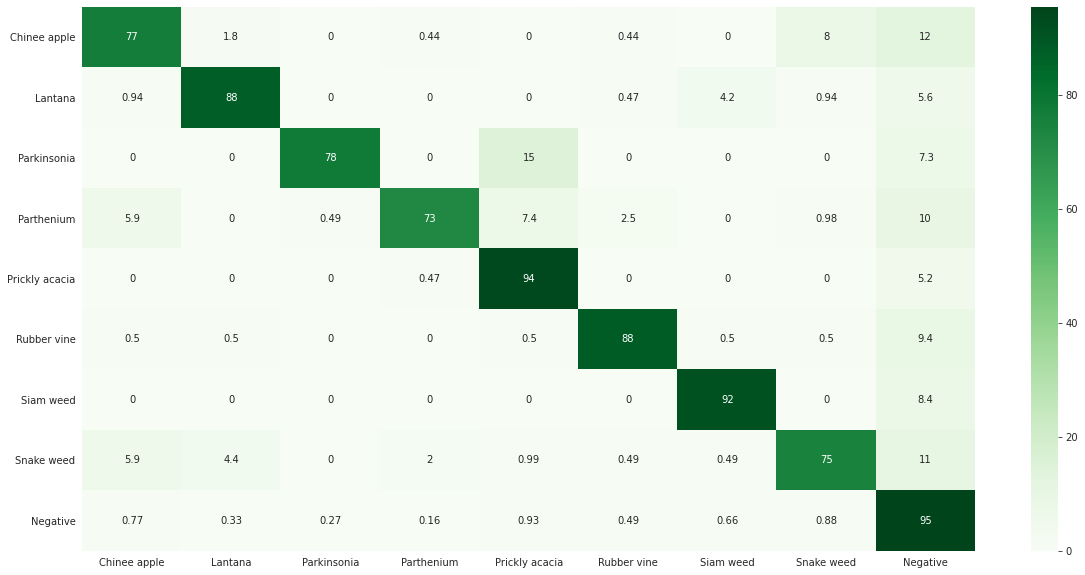

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_gen.classes, y_pred, labels=[0, 1, 3, 4, 5, 6, 7, 8, 2])
mat = ((cf_matrix / cf_matrix.sum(axis=1, keepdims=True) )* 100)
fig = plt.subplots(figsize = (20, 10))
sns.heatmap(mat, annot=True, cmap='Greens', yticklabels=CLASSES, xticklabels=CLASSES)

Confusion Matrix


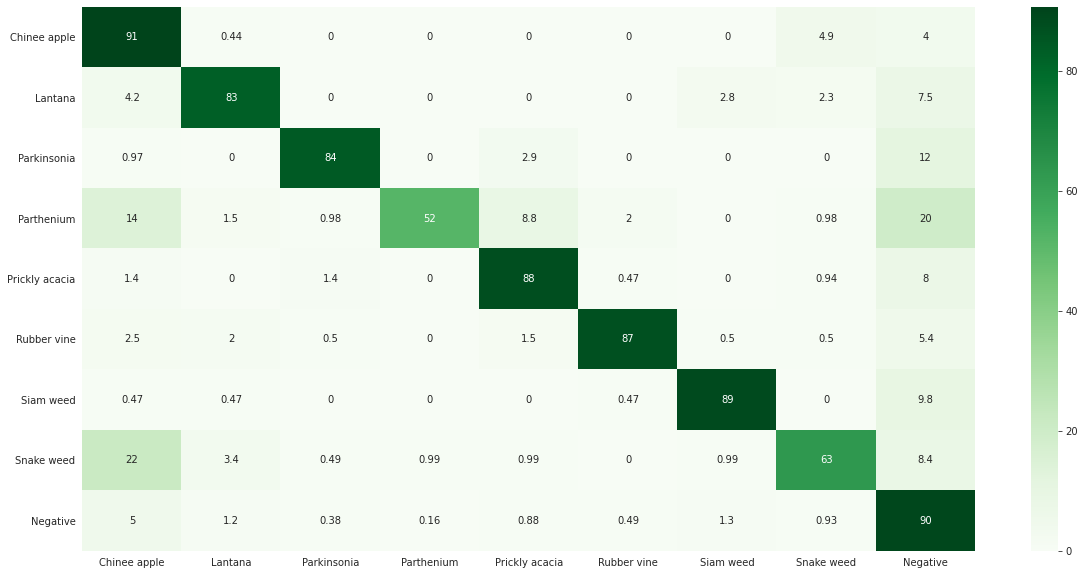

In [ ]:
# Old
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_gen.classes, y_pred, labels=[0, 1, 3, 4, 5, 6, 7, 8, 2])
mat = ((cf_matrix / cf_matrix.sum(axis=1, keepdims=True) )* 100)
fig = plt.subplots(figsize = (20, 10))
sns.heatmap(mat, annot=True, cmap='Greens', yticklabels=CLASSES, xticklabels=CLASSES)

In [ ]:
print(num2class)
print(classification_report(test_image_gen.classes, y_pred))

{0: 'Chinee apple', 1: 'Lantana', 2: 'Negative', 3: 'Parkinsonia', 4: 'Parthenium', 5: 'Prickly acacia', 6: 'Rubber vine', 7: 'Siam weed', 8: 'Snake weed'}
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       225
           1       0.88      0.91      0.89       213
           2       0.94      0.91      0.93      1821
           3       0.91      0.84      0.88       206
           4       0.89      0.75      0.81       204
           5       0.75      0.96      0.84       213
           6       0.88      0.91      0.90       202
           7       0.82      0.92      0.86       215
           8       0.78      0.79      0.79       203

    accuracy                           0.88      3502
   macro avg       0.84      0.86      0.85      3502
weighted avg       0.89      0.88      0.89      3502

